In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp

In [2]:
gckm_data = pd.read_csv("5000_rows_feta_syn_gckm.csv")
gmcm_data = pd.read_csv("6000_rows_feta_syn_gmcm.csv")
y_data = pd.read_csv("fetal_health_6000_ydata.csv")
real_data = pd.read_csv("fetal_health.csv")

In [3]:
real_data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [ ]:
##GCKM

In [14]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import type_of_target
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Load data
real_data = pd.read_csv("fetal_health.csv")
synthetic_data = pd.read_csv("5000_rows_feta_syn_gckm.csv")


target = 'fetal_health'
targets = real_data[target]
input_columns = real_data.drop(columns=[target]).columns.tolist()

# Split the data
X_train, X_val, y_train, y_val = train_test_split(real_data, targets, test_size=0.1, random_state=42)

numeric_cols = real_data.select_dtypes(include=np.number).columns.tolist()

def calculate_classification_metrics(y_test, y_pred, y_score=None):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Check if y_test is binary or multi-class
    target_type = type_of_target(y_test)
    
    if target_type == 'binary':
        # For binary classification, use y_pred
        auc = roc_auc_score(y_test, y_score)  # y_score is the predicted probabilities
    elif target_type == 'multiclass':
        # For multi-class, use one-vs-rest or one-vs-one
        y_test_binarized = label_binarize(np.array(y_test), classes=np.unique(y_test))
        auc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr', average='weighted')
    else:
        raise ValueError("y_test must be binary or multiclass")

    gini = 2 * auc - 1

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Gini Score": gini
    }

# Function to run the experiment
def run_experiment(real_data, synthetic_data, num_iterations=5):
    # Collecting metrics
    metrics = []
    all_metric = []

    for i in range(num_iterations): 
        # Data Augmentation
        num_of_rows_for_aug = round(len(real_data) / 2)
        augmented_data = synthetic_data.sample(n=num_of_rows_for_aug)
        augmented_targets = augmented_data[target]
        augmented_train = pd.concat([X_train, augmented_data])
        augmented_target = pd.concat([y_train, augmented_targets])

        # Data Preprocessing (encoding)
        scaler = MinMaxScaler()
        numeric_columns = augmented_train.select_dtypes(include=np.number).columns.tolist()
        augmented_train[numeric_columns] = scaler.fit_transform(augmented_train[numeric_columns])
        
        
        X_val_scaled = X_val.copy()
        X_val_scaled[numeric_columns] = scaler.transform(X_val_scaled[numeric_columns])
        augmented_train = augmented_train[input_columns]
        X_val_scaled = X_val_scaled[input_columns]


        gb = GradientBoostingClassifier(random_state=1)
        param_dist = {
            'n_estimators': np.arange(50, 151, 10),
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 3, 4],
            'min_samples_leaf': [1, 2, 3]
        }
        random_search = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=123)
        random_search.fit(augmented_train, augmented_target)

        # Best model
        gbc_cv = random_search.best_estimator_
        y_pred_gbc_cv = gbc_cv.predict(X_val_scaled)
        y_score_gbc_cv = gbc_cv.predict_proba(X_val_scaled)  # Probability estimates

        model_metrics = calculate_classification_metrics(y_val, y_pred_gbc_cv, y_score_gbc_cv)
        all_metric.append(model_metrics)
        print(f"Iteration {i+1}:")
        print(model_metrics)
        print("\n")
    return all_metric

# Run the experiment
all_metric = run_experiment(real_data, synthetic_data, num_iterations=5)
print(all_metric)

Iteration 1:
{'Accuracy': 0.9530516431924883, 'Precision': 0.9530516431924883, 'Recall': 0.9530516431924883, 'F1 Score': 0.9530516431924883, 'Gini Score': 0.9667972261272173}


Iteration 2:
{'Accuracy': 0.9530516431924883, 'Precision': 0.952762187158036, 'Recall': 0.9530516431924883, 'F1 Score': 0.9528175269099689, 'Gini Score': 0.9660505955882734}


Iteration 3:
{'Accuracy': 0.9389671361502347, 'Precision': 0.9379557663385868, 'Recall': 0.9389671361502347, 'F1 Score': 0.9373605925214081, 'Gini Score': 0.9625530801626927}


Iteration 4:
{'Accuracy': 0.9436619718309859, 'Precision': 0.9458909261546743, 'Recall': 0.9436619718309859, 'F1 Score': 0.9444494817003286, 'Gini Score': 0.9674839158407234}


Iteration 5:
{'Accuracy': 0.9530516431924883, 'Precision': 0.9531983568075117, 'Recall': 0.9530516431924883, 'F1 Score': 0.9530508022008751, 'Gini Score': 0.9633548907202127}


[{'Accuracy': 0.9530516431924883, 'Precision': 0.9530516431924883, 'Recall': 0.9530516431924883, 'F1 Score': 0.95305

In [4]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import type_of_target
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Load data
real_data = pd.read_csv("fetal_health.csv")
synthetic_data = pd.read_csv("fetal_health_6000_ydata.csv")


target = 'fetal_health'
targets = real_data[target]
input_columns = real_data.drop(columns=[target]).columns.tolist()

# Split the data
X_train, X_val, y_train, y_val = train_test_split(real_data, targets, test_size=0.1, random_state=42)

numeric_cols = real_data.select_dtypes(include=np.number).columns.tolist()

def calculate_classification_metrics(y_test, y_pred, y_score=None):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Check if y_test is binary or multi-class
    target_type = type_of_target(y_test)
    
    if target_type == 'binary':
        # For binary classification, use y_pred
        auc = roc_auc_score(y_test, y_score)  # y_score is the predicted probabilities
    elif target_type == 'multiclass':
        # For multi-class, use one-vs-rest or one-vs-one
        y_test_binarized = label_binarize(np.array(y_test), classes=np.unique(y_test))
        auc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr', average='weighted')
    else:
        raise ValueError("y_test must be binary or multiclass")

    gini = 2 * auc - 1

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Gini Score": gini
    }

# Function to run the experiment
def run_experiment(real_data, synthetic_data, num_iterations=5):
    # Collecting metrics
    metrics = []
    all_metric = []

    for i in range(num_iterations):  
        # Data Augmentation
        num_of_rows_for_aug = round(len(real_data) / 2)
        augmented_data = synthetic_data.sample(n=num_of_rows_for_aug)
        augmented_targets = augmented_data[target]
        augmented_train = pd.concat([X_train, augmented_data])
        augmented_target = pd.concat([y_train, augmented_targets])

        # Data Preprocessing (encoding)
        scaler = MinMaxScaler()
        numeric_columns = augmented_train.select_dtypes(include=np.number).columns.tolist()
        augmented_train[numeric_columns] = scaler.fit_transform(augmented_train[numeric_columns])
        
        
        X_val_scaled = X_val.copy()
        X_val_scaled[numeric_columns] = scaler.transform(X_val_scaled[numeric_columns])
        augmented_train = augmented_train[input_columns]
        X_val_scaled = X_val_scaled[input_columns]


        gb = GradientBoostingClassifier(random_state=1)
        param_dist = {
            'n_estimators': np.arange(50, 151, 10),
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 3, 4],
            'min_samples_leaf': [1, 2, 3]
        }
        random_search = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=123)
        random_search.fit(augmented_train, augmented_target)

        # Best model
        gbc_cv = random_search.best_estimator_
        y_pred_gbc_cv = gbc_cv.predict(X_val_scaled)
        y_score_gbc_cv = gbc_cv.predict_proba(X_val_scaled)  # Probability estimates

        model_metrics = calculate_classification_metrics(y_val, y_pred_gbc_cv, y_score_gbc_cv)
        all_metric.append(model_metrics)
        print(f"Iteration {i+1}:")
        print(model_metrics)
        print("\n")
    return all_metric

# Run the experiment
all_metric = run_experiment(real_data, synthetic_data, num_iterations=5)
print(all_metric)

Iteration 1:
{'Accuracy': 0.9577464788732394, 'Precision': 0.9574570228387872, 'Recall': 0.9577464788732394, 'F1 Score': 0.95751236259072, 'Gini Score': 0.9775425939188174}


Iteration 2:
{'Accuracy': 0.9624413145539906, 'Precision': 0.9625992687191325, 'Recall': 0.9624413145539906, 'F1 Score': 0.9624529225542243, 'Gini Score': 0.9823052144210733}


Iteration 3:
{'Accuracy': 0.9577464788732394, 'Precision': 0.9582917736777605, 'Recall': 0.9577464788732394, 'F1 Score': 0.9579840508270081, 'Gini Score': 0.9798933443239963}


Iteration 4:
{'Accuracy': 0.9577464788732394, 'Precision': 0.9582620595278822, 'Recall': 0.9577464788732394, 'F1 Score': 0.9579692406198133, 'Gini Score': 0.96990059208568}


Iteration 5:
{'Accuracy': 0.9483568075117371, 'Precision': 0.9484553333771226, 'Recall': 0.9483568075117371, 'F1 Score': 0.9483387950975812, 'Gini Score': 0.978812822530496}


[{'Accuracy': 0.9577464788732394, 'Precision': 0.9574570228387872, 'Recall': 0.9577464788732394, 'F1 Score': 0.957512362

In [5]:
all_metric_gckm = [{'Accuracy': 0.9530516431924883, 'Precision': 0.9530516431924883, 'Recall': 0.9530516431924883, 'F1 Score': 0.9530516431924883, 'Gini Score': 0.9667972261272173}, {'Accuracy': 0.9530516431924883, 'Precision': 0.952762187158036, 'Recall': 0.9530516431924883, 'F1 Score': 0.9528175269099689, 'Gini Score': 0.9660505955882734}, {'Accuracy': 0.9389671361502347, 'Precision': 0.9379557663385868, 'Recall': 0.9389671361502347, 'F1 Score': 0.9373605925214081, 'Gini Score': 0.9625530801626927}, {'Accuracy': 0.9436619718309859, 'Precision': 0.9458909261546743, 'Recall': 0.9436619718309859, 'F1 Score': 0.9444494817003286, 'Gini Score': 0.9674839158407234}, {'Accuracy': 0.9530516431924883, 'Precision': 0.9531983568075117, 'Recall': 0.9530516431924883, 'F1 Score': 0.9530508022008751, 'Gini Score': 0.9633548907202127}]
all_metric_gmcm = [{'Accuracy': 0.9624413145539906, 'Precision': 0.962330504767737, 'Recall': 0.9624413145539906, 'F1 Score': 0.9622601808031286, 'Gini Score': 0.9755709397628709}, {'Accuracy': 0.9624413145539906, 'Precision': 0.962330504767737, 'Recall': 0.9624413145539906, 'F1 Score': 0.9622601808031286, 'Gini Score': 0.9714655373125973}, {'Accuracy': 0.9624413145539906, 'Precision': 0.9619772816465355, 'Recall': 0.9624413145539906, 'F1 Score': 0.9620197163664868, 'Gini Score': 0.9765818177531396}, {'Accuracy': 0.9624413145539906, 'Precision': 0.9619044188404082, 'Recall': 0.9624413145539906, 'F1 Score': 0.9620221327967807, 'Gini Score': 0.9725913547828084}, {'Accuracy': 0.9577464788732394, 'Precision': 0.9574396268679616, 'Recall': 0.9577464788732394, 'F1 Score': 0.9573403035032626, 'Gini Score': 0.9677864764520288}]
all_metric_sdv = [{'Accuracy': 0.9577464788732394, 'Precision': 0.9577464788732394, 'Recall': 0.9577464788732394, 'F1 Score': 0.9577464788732394, 'Gini Score': 0.9612250417534101}, {'Accuracy': 0.9436619718309859, 'Precision': 0.9448384574965718, 'Recall': 0.9436619718309859, 'F1 Score': 0.9437278387330994, 'Gini Score': 0.9571304758063728}, {'Accuracy': 0.9671361502347418, 'Precision': 0.9668511066398391, 'Recall': 0.9671361502347418, 'F1 Score': 0.9669562254093239, 'Gini Score': 0.9654916315217104}, {'Accuracy': 0.9483568075117371, 'Precision': 0.9478621730382294, 'Recall': 0.9483568075117371, 'F1 Score': 0.9480740685003659, 'Gini Score': 0.9549614068592343}, {'Accuracy': 0.9483568075117371, 'Precision': 0.9479963112005365, 'Recall': 0.9483568075117371, 'F1 Score': 0.9481401929465736, 'Gini Score': 0.9625198451966974}]
all_metric_y_data = all_metric



In [6]:
all_metrics_df_gckm = pd.DataFrame(all_metric_gckm)
all_metrics_df_gckm

,Accuracy,Precision,Recall,F1 Score,Gini Score
0,0.953052,0.953052,0.953052,0.953052,0.966797
1,0.953052,0.952762,0.953052,0.952818,0.966051
2,0.938967,0.937956,0.938967,0.937361,0.962553
3,0.943662,0.945891,0.943662,0.944449,0.967484
4,0.953052,0.953198,0.953052,0.953051,0.963355


In [7]:
all_metrics_df_gmcm = pd.DataFrame(all_metric_gmcm)
all_metrics_df_sdv = pd.DataFrame(all_metric_sdv)
all_metrics_df_y_data = pd.DataFrame(all_metric_y_data)

In [11]:
all_metrics_df_gmcm

,Accuracy,Precision,Recall,F1 Score,Gini Score
0,0.962441,0.962331,0.962441,0.962260,0.975571
1,0.962441,0.962331,0.962441,0.962260,0.971466
2,0.962441,0.961977,0.962441,0.962020,0.976582
3,0.962441,0.961904,0.962441,0.962022,0.972591
4,0.957746,0.957440,0.957746,0.957340,0.967786


In [12]:
all_metrics_df_y_data

,Accuracy,Precision,Recall,F1 Score,Gini Score
0,0.957746,0.957457,0.957746,0.957512,0.977543
1,0.962441,0.962599,0.962441,0.962453,0.982305
2,0.957746,0.958292,0.957746,0.957984,0.979893
3,0.957746,0.958262,0.957746,0.957969,0.969901
4,0.948357,0.948455,0.948357,0.948339,0.978813


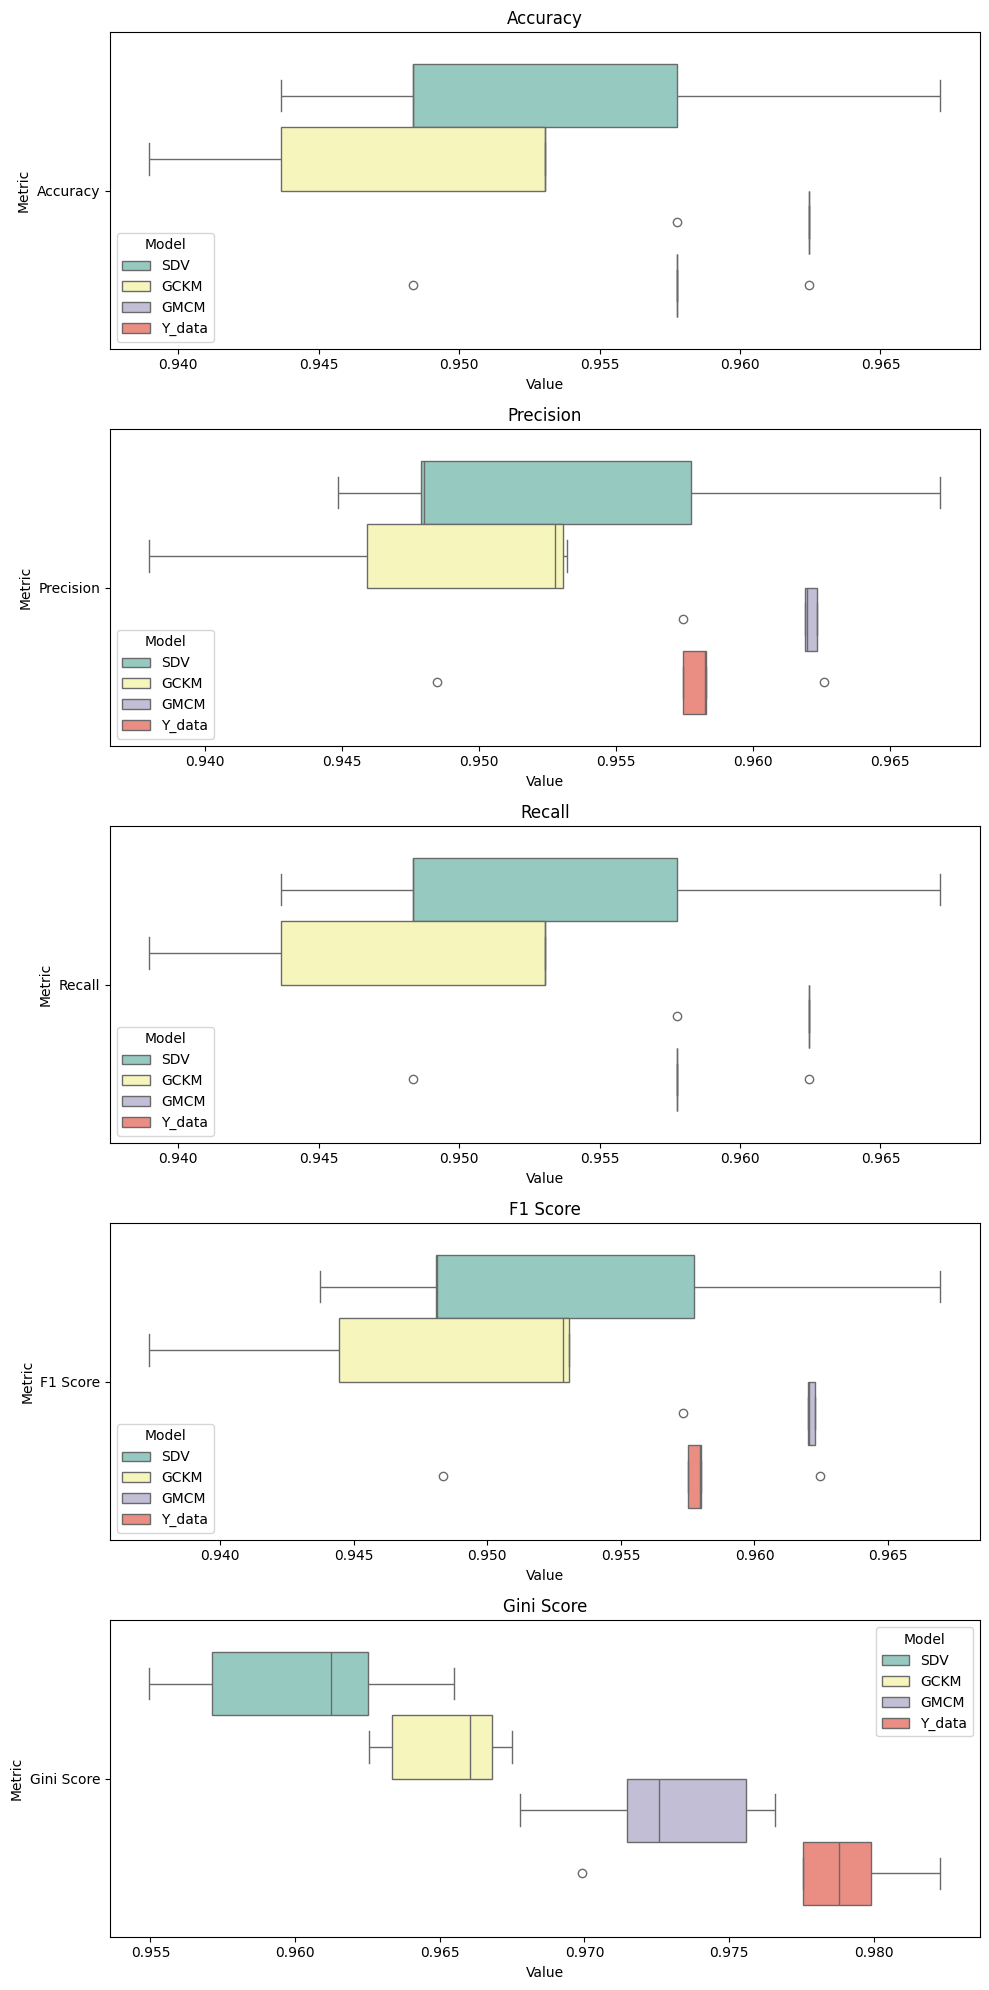

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


metrics_df_sdv_melted = all_metrics_df_sdv.melt(var_name='Metric', value_name='Value')
metrics_df_sdv_melted['Model'] = 'SDV'
metrics_df_gckm_melted = all_metrics_df_gckm.melt(var_name='Metric', value_name='Value')
metrics_df_gckm_melted['Model'] = 'GCKM'
metrics_df_gmcm_melted = all_metrics_df_gmcm.melt(var_name='Metric', value_name='Value')
metrics_df_gmcm_melted['Model'] = 'GMCM'
metrics_df_y_data_melted = all_metrics_df_y_data.melt(var_name='Metric', value_name='Value')
metrics_df_y_data_melted['Model'] = 'Y_data'

combined_metrics_df = pd.concat([metrics_df_sdv_melted, metrics_df_gckm_melted, metrics_df_gmcm_melted, metrics_df_y_data_melted])


fig, axes = plt.subplots(5, 1, figsize=(10, 20), sharex=False)


for ax, metric in zip(axes, combined_metrics_df['Metric'].unique()):
    sns.boxplot(data=combined_metrics_df[combined_metrics_df['Metric'] == metric], 
                 y='Metric', x='Value', hue='Model', ax=ax, orient='h', palette="Set3")
    ax.set_title(metric)


plt.tight_layout()
plt.show()

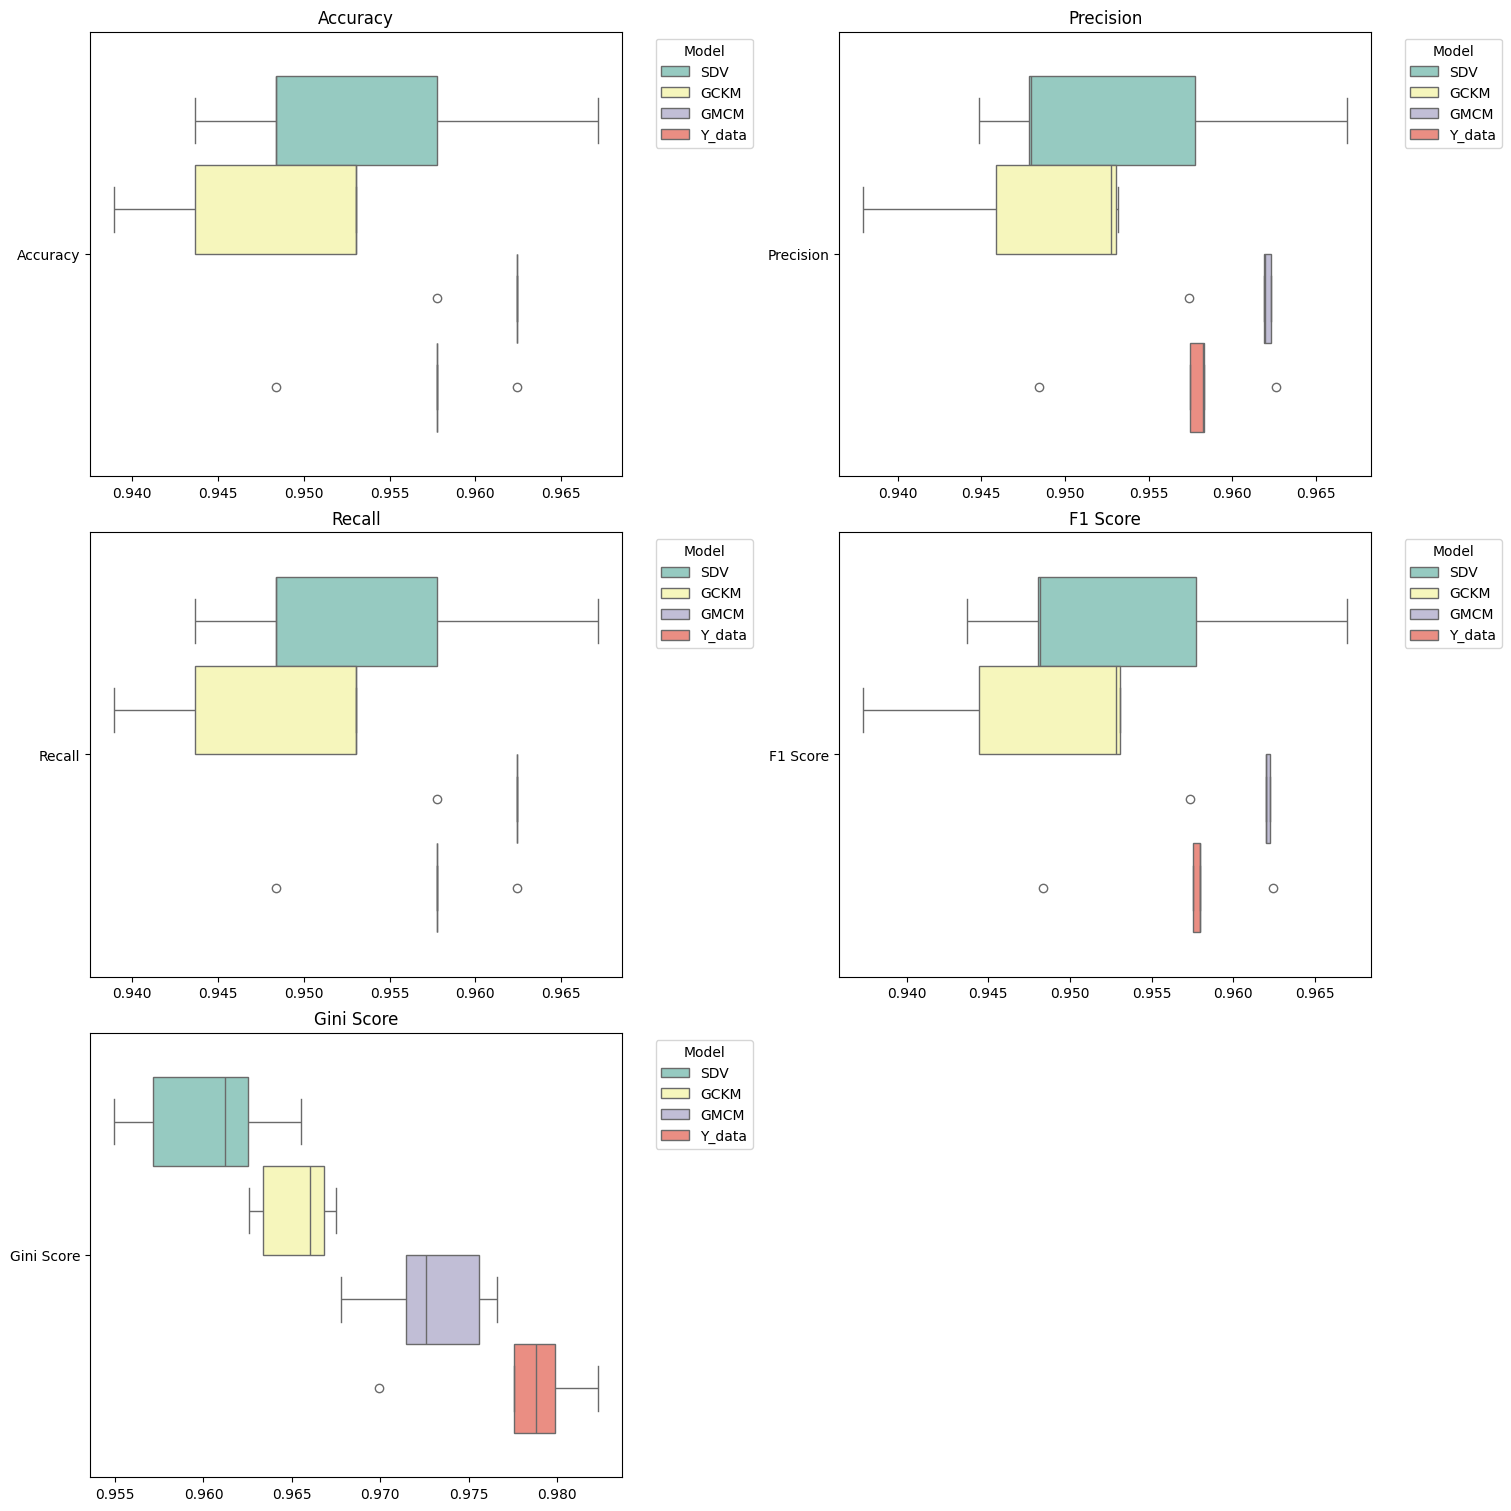

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15), constrained_layout=True)


(ax1, ax2), (ax3, ax4), (ax5, ax6) = axes

axes_dict = {
    'Accuracy': ax1,
    'Precision': ax2,
    'Recall': ax3,
    'F1 Score': ax4,
    'Gini Score': ax5
}

# Removing the unused axis
fig.delaxes(ax6)

# Plotting boxplots for each metric
for metric, ax in axes_dict.items():
    sns.boxplot(data=combined_metrics_df[combined_metrics_df['Metric'] == metric], 
                 y='Metric', x='Value', hue='Model', ax=ax, orient='h', palette="Set3")
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout and display the plot
plt.show()

In [17]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import type_of_target
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Load data
real_data = pd.read_csv("fetal_health.csv")
synthetic_data = pd.read_csv("6000_rows_feta_syn_gmcm.csv")


target = 'fetal_health'
targets = real_data[target]
input_columns = real_data.drop(columns=[target]).columns.tolist()

# Split the data
X_train, X_val, y_train, y_val = train_test_split(real_data, targets, test_size=0.1, random_state=42)

numeric_cols = real_data.select_dtypes(include=np.number).columns.tolist()

def calculate_classification_metrics(y_test, y_pred, y_score=None):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Check if y_test is binary or multi-class
    target_type = type_of_target(y_test)
    
    if target_type == 'binary':
        # For binary classification, use y_pred
        auc = roc_auc_score(y_test, y_score)  # y_score is the predicted probabilities
    elif target_type == 'multiclass':
        # For multi-class, use one-vs-rest or one-vs-one
        y_test_binarized = label_binarize(np.array(y_test), classes=np.unique(y_test))
        auc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr', average='weighted')
    else:
        raise ValueError("y_test must be binary or multiclass")

    gini = 2 * auc - 1

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Gini Score": gini
    }

# Function to run the experiment
def run_experiment(real_data, synthetic_data, num_iterations=5):
    # Collecting metrics
    metrics = []
    all_metric = []

    for i in range(num_iterations): 
        # Data Augmentation
        num_of_rows_for_aug = round(len(real_data) / 2)
        augmented_data = synthetic_data.sample(n=num_of_rows_for_aug)
        augmented_targets = augmented_data[target]
        augmented_train = pd.concat([X_train, augmented_data])
        augmented_target = pd.concat([y_train, augmented_targets])

        # Data Preprocessing (encoding)
        scaler = MinMaxScaler()
        numeric_columns = augmented_train.select_dtypes(include=np.number).columns.tolist()
        augmented_train[numeric_columns] = scaler.fit_transform(augmented_train[numeric_columns])
        
        
        X_val_scaled = X_val.copy()
        X_val_scaled[numeric_columns] = scaler.transform(X_val_scaled[numeric_columns])
        augmented_train = augmented_train[input_columns]
        X_val_scaled = X_val_scaled[input_columns]


        gb = GradientBoostingClassifier(random_state=1)
        param_dist = {
            'n_estimators': np.arange(50, 151, 10),
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 3, 4],
            'min_samples_leaf': [1, 2, 3]
        }
        random_search = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=123)
        random_search.fit(augmented_train, augmented_target)

        # Best model
        gbc_cv = random_search.best_estimator_
        y_pred_gbc_cv = gbc_cv.predict(X_val_scaled)
        y_score_gbc_cv = gbc_cv.predict_proba(X_val_scaled)  # Probability estimates

        model_metrics = calculate_classification_metrics(y_val, y_pred_gbc_cv, y_score_gbc_cv)
        all_metric.append(model_metrics)
        print(f"Iteration {i+1}:")
        print(model_metrics)
        print("\n")
    return all_metric

# Run the experiment
all_metric = run_experiment(real_data, synthetic_data, num_iterations=5)
print(all_metric)

Iteration 1:
{'Accuracy': 0.9624413145539906, 'Precision': 0.962330504767737, 'Recall': 0.9624413145539906, 'F1 Score': 0.9622601808031286, 'Gini Score': 0.9755709397628709}


Iteration 2:
{'Accuracy': 0.9624413145539906, 'Precision': 0.962330504767737, 'Recall': 0.9624413145539906, 'F1 Score': 0.9622601808031286, 'Gini Score': 0.9714655373125973}


Iteration 3:
{'Accuracy': 0.9624413145539906, 'Precision': 0.9619772816465355, 'Recall': 0.9624413145539906, 'F1 Score': 0.9620197163664868, 'Gini Score': 0.9765818177531396}


Iteration 4:
{'Accuracy': 0.9624413145539906, 'Precision': 0.9619044188404082, 'Recall': 0.9624413145539906, 'F1 Score': 0.9620221327967807, 'Gini Score': 0.9725913547828084}


Iteration 5:
{'Accuracy': 0.9577464788732394, 'Precision': 0.9574396268679616, 'Recall': 0.9577464788732394, 'F1 Score': 0.9573403035032626, 'Gini Score': 0.9677864764520288}


[{'Accuracy': 0.9624413145539906, 'Precision': 0.962330504767737, 'Recall': 0.9624413145539906, 'F1 Score': 0.9622601

In [18]:
all_metrics_df_gmcm = pd.DataFrame(all_metric)

all_metrics_df_gmcm

,Accuracy,Precision,Recall,F1 Score,Gini Score
0,0.962441,0.962331,0.962441,0.962260,0.975571
1,0.962441,0.962331,0.962441,0.962260,0.971466
2,0.962441,0.961977,0.962441,0.962020,0.976582
3,0.962441,0.961904,0.962441,0.962022,0.972591
4,0.957746,0.957440,0.957746,0.957340,0.967786


In [19]:
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import GaussianCopulaSynthesizer
metadata1 = SingleTableMetadata()
data = real_data
metadata1.detect_from_dataframe(data = data)
synthesier = GaussianCopulaSynthesizer(metadata1)
synthesier.fit(data)
synthetic_data = synthesier.sample(num_rows = 5000)  #keep the number of rows equal to the data hold



In [20]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import type_of_target
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Load data
real_data = pd.read_csv("fetal_health.csv")
synthetic_data = synthetic_data


target = 'fetal_health'
targets = real_data[target]
input_columns = real_data.drop(columns=[target]).columns.tolist()

# Split the data
X_train, X_val, y_train, y_val = train_test_split(real_data, targets, test_size=0.1, random_state=42)

numeric_cols = real_data.select_dtypes(include=np.number).columns.tolist()

def calculate_classification_metrics(y_test, y_pred, y_score=None):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Check if y_test is binary or multi-class
    target_type = type_of_target(y_test)
    
    if target_type == 'binary':
        # For binary classification, use y_pred
        auc = roc_auc_score(y_test, y_score)  # y_score is the predicted probabilities
    elif target_type == 'multiclass':
        # For multi-class, use one-vs-rest or one-vs-one
        y_test_binarized = label_binarize(np.array(y_test), classes=np.unique(y_test))
        auc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr', average='weighted')
    else:
        raise ValueError("y_test must be binary or multiclass")

    gini = 2 * auc - 1

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Gini Score": gini
    }

# Function to run the experiment
def run_experiment(real_data, synthetic_data, num_iterations=5):
    # Collecting metrics
    metrics = []
    all_metric = []

    for i in range(num_iterations):
        # Data Augmentation
        num_of_rows_for_aug = round(len(real_data) / 2)
        augmented_data = synthetic_data.sample(n=num_of_rows_for_aug)
        augmented_targets = augmented_data[target]
        augmented_train = pd.concat([X_train, augmented_data])
        augmented_target = pd.concat([y_train, augmented_targets])

        # Data Preprocessing (encoding)
        scaler = MinMaxScaler()
        numeric_columns = augmented_train.select_dtypes(include=np.number).columns.tolist()
        augmented_train[numeric_columns] = scaler.fit_transform(augmented_train[numeric_columns])
        
        
        X_val_scaled = X_val.copy()
        X_val_scaled[numeric_columns] = scaler.transform(X_val_scaled[numeric_columns])
        augmented_train = augmented_train[input_columns]
        X_val_scaled = X_val_scaled[input_columns]


        gb = GradientBoostingClassifier(random_state=1)
        param_dist = {
            'n_estimators': np.arange(50, 151, 10),
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 3, 4],
            'min_samples_leaf': [1, 2, 3]
        }
        random_search = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=123)
        random_search.fit(augmented_train, augmented_target)

        # Best model
        gbc_cv = random_search.best_estimator_
        y_pred_gbc_cv = gbc_cv.predict(X_val_scaled)
        y_score_gbc_cv = gbc_cv.predict_proba(X_val_scaled)  # Probability estimates

        model_metrics = calculate_classification_metrics(y_val, y_pred_gbc_cv, y_score_gbc_cv)
        all_metric.append(model_metrics)
        print(f"Iteration {i+1}:")
        print(model_metrics)
        print("\n")
    return all_metric

# Run the experiment
all_metric = run_experiment(real_data, synthetic_data, num_iterations=5)
print(all_metric)

Iteration 1:
{'Accuracy': 0.9577464788732394, 'Precision': 0.9577464788732394, 'Recall': 0.9577464788732394, 'F1 Score': 0.9577464788732394, 'Gini Score': 0.9612250417534101}


Iteration 2:
{'Accuracy': 0.9436619718309859, 'Precision': 0.9448384574965718, 'Recall': 0.9436619718309859, 'F1 Score': 0.9437278387330994, 'Gini Score': 0.9571304758063728}


Iteration 3:
{'Accuracy': 0.9671361502347418, 'Precision': 0.9668511066398391, 'Recall': 0.9671361502347418, 'F1 Score': 0.9669562254093239, 'Gini Score': 0.9654916315217104}


Iteration 4:
{'Accuracy': 0.9483568075117371, 'Precision': 0.9478621730382294, 'Recall': 0.9483568075117371, 'F1 Score': 0.9480740685003659, 'Gini Score': 0.9549614068592343}


Iteration 5:
{'Accuracy': 0.9483568075117371, 'Precision': 0.9479963112005365, 'Recall': 0.9483568075117371, 'F1 Score': 0.9481401929465736, 'Gini Score': 0.9625198451966974}


[{'Accuracy': 0.9577464788732394, 'Precision': 0.9577464788732394, 'Recall': 0.9577464788732394, 'F1 Score': 0.9577

In [21]:
all_metrics_df_sdv = pd.DataFrame(all_metric)

all_metrics_df_sdv

,Accuracy,Precision,Recall,F1 Score,Gini Score
0,0.957746,0.957746,0.957746,0.957746,0.961225
1,0.943662,0.944838,0.943662,0.943728,0.957130
2,0.967136,0.966851,0.967136,0.966956,0.965492
3,0.948357,0.947862,0.948357,0.948074,0.954961
4,0.948357,0.947996,0.948357,0.948140,0.962520


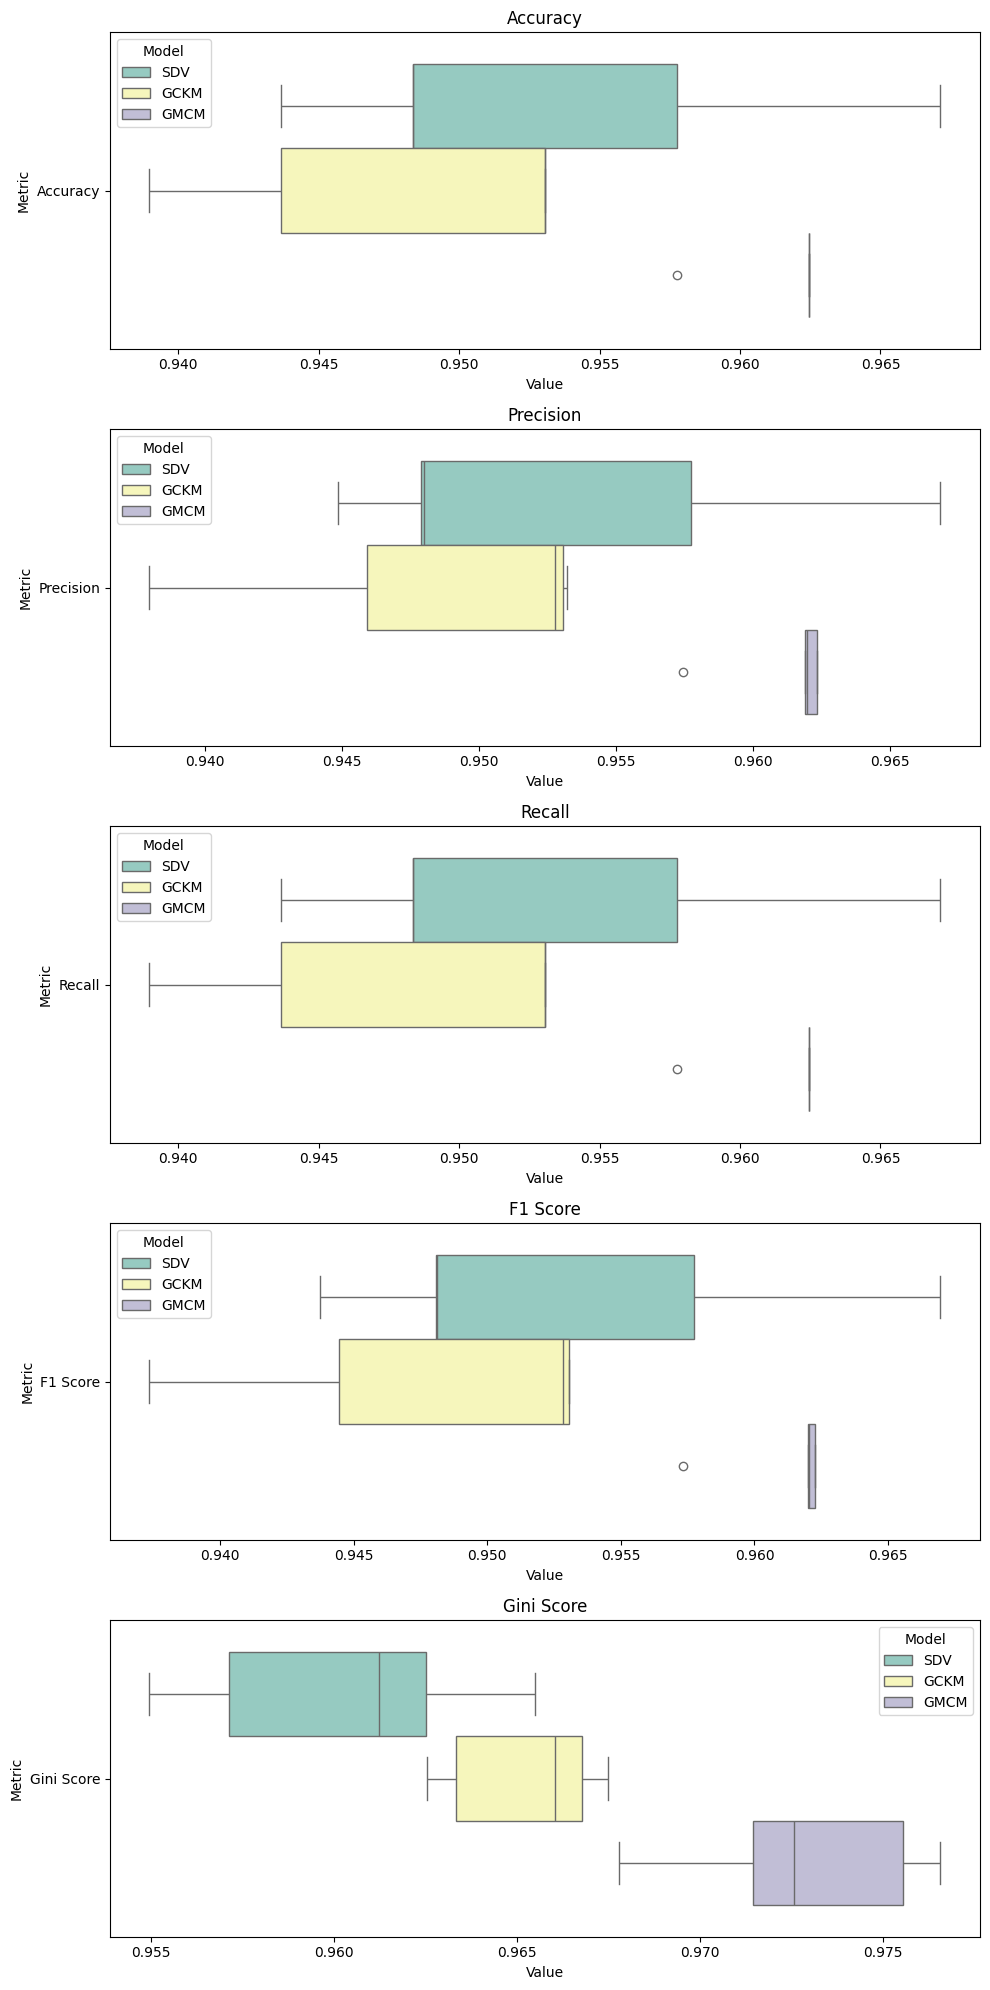

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


metrics_df_sdv_melted = all_metrics_df_sdv.melt(var_name='Metric', value_name='Value')
metrics_df_sdv_melted['Model'] = 'SDV'
metrics_df_gckm_melted = all_metrics_df_gckm.melt(var_name='Metric', value_name='Value')
metrics_df_gckm_melted['Model'] = 'GCKM'
metrics_df_gmcm_melted = all_metrics_df_gmcm.melt(var_name='Metric', value_name='Value')
metrics_df_gmcm_melted['Model'] = 'GMCM'


combined_metrics_df = pd.concat([metrics_df_sdv_melted, metrics_df_gckm_melted, metrics_df_gmcm_melted])


fig, axes = plt.subplots(5, 1, figsize=(10, 20), sharex=False)


for ax, metric in zip(axes, combined_metrics_df['Metric'].unique()):
    sns.boxplot(data=combined_metrics_df[combined_metrics_df['Metric'] == metric], 
                 y='Metric', x='Value', hue='Model', ax=ax, orient='h', palette="Set3")
    ax.set_title(metric)


plt.tight_layout()
plt.show()

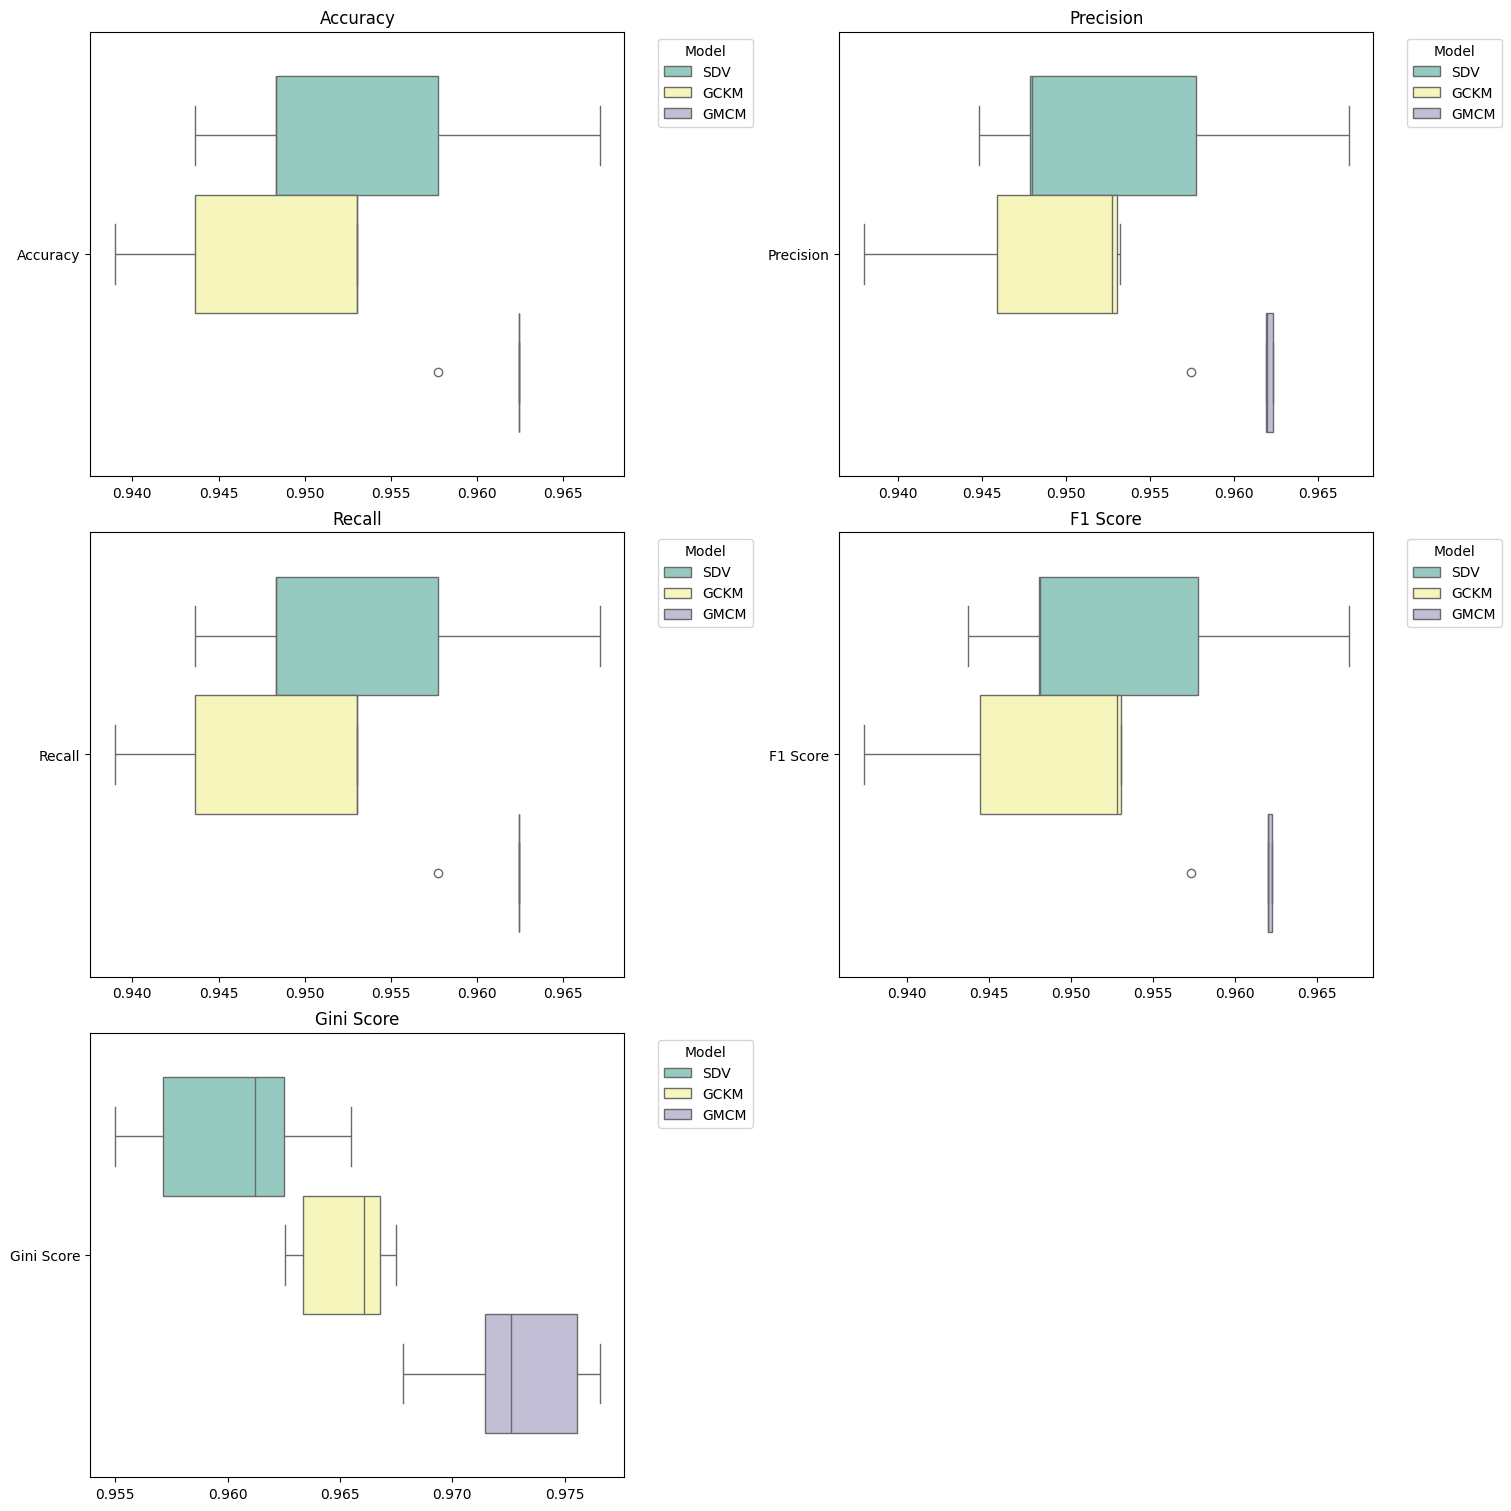

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15), constrained_layout=True)


(ax1, ax2), (ax3, ax4), (ax5, ax6) = axes

axes_dict = {
    'Accuracy': ax1,
    'Precision': ax2,
    'Recall': ax3,
    'F1 Score': ax4,
    'Gini Score': ax5
}

# Removing the unused axis
fig.delaxes(ax6)

# Plotting boxplots for each metric
for metric, ax in axes_dict.items():
    sns.boxplot(data=combined_metrics_df[combined_metrics_df['Metric'] == metric], 
                 y='Metric', x='Value', hue='Model', ax=ax, orient='h', palette="Set3")
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout and display the plot
plt.show()